MSE: 254.63
MAE: 13.73
R² Score: 0.55


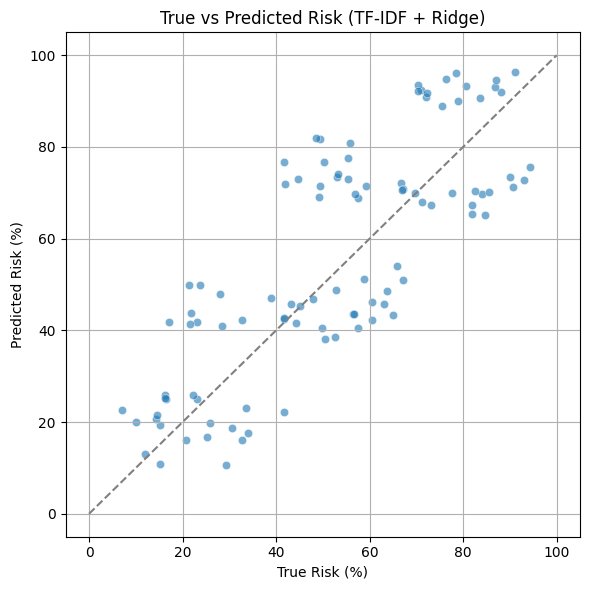

In [6]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('Synthetic_Criminal_Risk_Dataset.csv')

df['Criminal Record'] = df['Criminal Record'].fillna('No criminal record')

# הכנת הטקסט
df['input_text'] = df['Name']+ "," + df['Gender'] + ", " + df['Criminal Record'] + "," + df['Case Description']

# פיצול
X_train, X_test, y_train, y_test = train_test_split(
    df['input_text'], df['Risk Level (%)'], test_size=0.2, random_state=42
)

# מודל: TF-IDF + Ridge
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000, ngram_range=(1, 2))),
    ('ridge', Ridge(alpha=1.0))
])

# שליפת המגדרים של סט האימון מתוך df
train_gender = df.loc[X_train.index, 'Gender']

# הוספת הטיה אקראית עם תוחלת 20 וסטיית תקן 5
male_bias = np.random.normal(loc=20, scale=5, size=(train_gender == 'Male').sum())
female_bias = np.random.normal(loc=-10, scale=5, size=(train_gender == 'Female').sum())

# העתקת תוויות אימון והחלת ההטיות
y_train_adjusted = y_train.copy()
y_train_adjusted.loc[train_gender == 'Male'] += male_bias
y_train_adjusted.loc[train_gender == 'Female'] += female_bias

# תחום בין 0 ל-100
y_train_adjusted = y_train_adjusted.clip(lower=0, upper=100)

# אימון
pipeline.fit(X_train, y_train_adjusted)

# חיזוי
y_pred = pipeline.predict(X_test)

# מדדים
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# גרף True vs Predicted
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([0, 100], [0, 100], linestyle='--', color='gray')
plt.title('True vs Predicted Risk (TF-IDF + Ridge)')
plt.xlabel('True Risk (%)')
plt.ylabel('Predicted Risk (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


📊 Evaluation Metrics:
MSE (Mean Squared Error): 254.63
MAE (Mean Absolute Error): 13.73
R² Score: 0.55


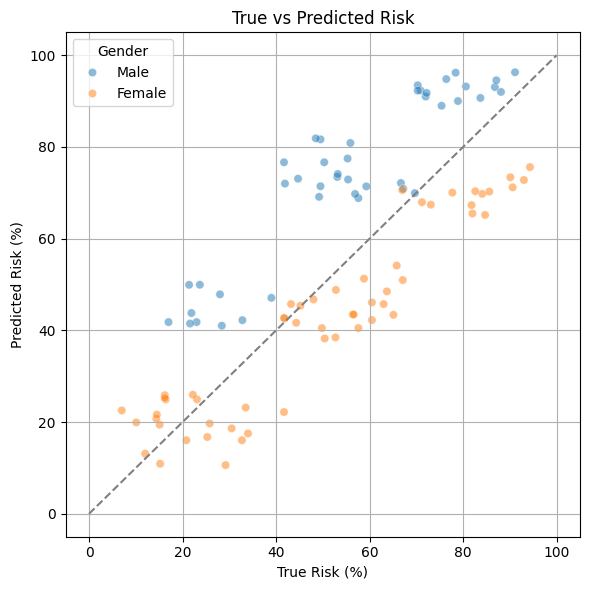

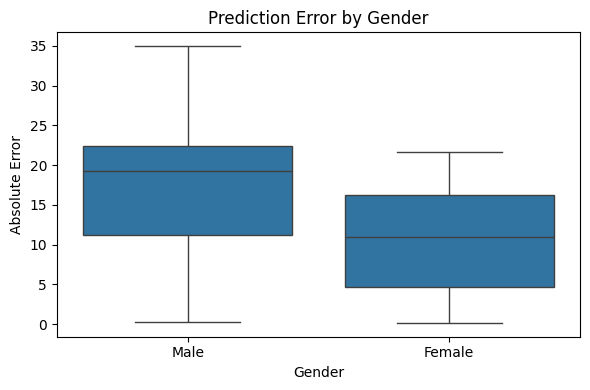

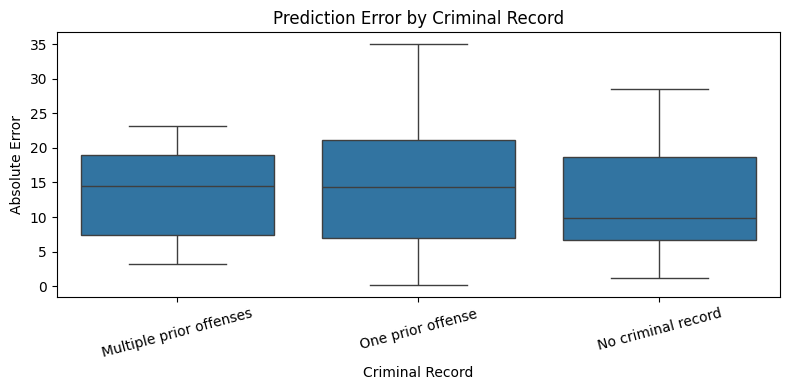

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# יצירת DataFrame עם תחזיות ותוויות אמת
eval_df = pd.DataFrame({
    'True Risk': y_test,
    'Predicted Risk': y_pred
})

# הוספת משתנים מקוריים לפי אינדקס
eval_df['Gender'] = df.loc[y_test.index, 'Gender'].values
eval_df['Criminal Record'] = df.loc[y_test.index, 'Criminal Record'].values
eval_df['Case Description'] = df.loc[y_test.index, 'Case Description'].values

# חישוב מדדים
mse = mean_squared_error(eval_df['True Risk'], eval_df['Predicted Risk'])
mae = mean_absolute_error(eval_df['True Risk'], eval_df['Predicted Risk'])
r2 = r2_score(eval_df['True Risk'], eval_df['Predicted Risk'])

print(f"📊 Evaluation Metrics:")
print(f"MSE (Mean Squared Error): {mse:.2f}")
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# גרף: תחזיות מול ערכים אמיתיים
plt.figure(figsize=(6, 6))
sns.scatterplot(data=eval_df, x='True Risk', y='Predicted Risk',hue='Gender', alpha=0.5)
plt.plot([0, 100], [0, 100], linestyle='--', color='gray')
plt.title('True vs Predicted Risk')
plt.xlabel('True Risk (%)')
plt.ylabel('Predicted Risk (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

# גרף: שגיאה מוחלטת לפי מגדר
eval_df['Absolute Error'] = abs(eval_df['True Risk'] - eval_df['Predicted Risk'])
plt.figure(figsize=(6, 4))
sns.boxplot(data=eval_df, x='Gender', y='Absolute Error')
plt.title('Prediction Error by Gender')
plt.tight_layout()
plt.show()

# גרף: שגיאה מוחלטת לפי עבר פלילי
plt.figure(figsize=(8, 4))
sns.boxplot(data=eval_df, x='Criminal Record', y='Absolute Error')
plt.title('Prediction Error by Criminal Record')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


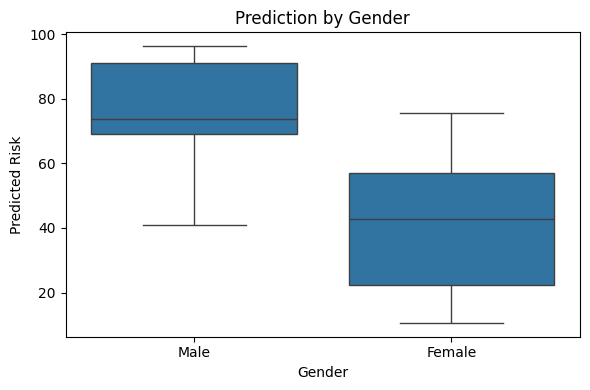

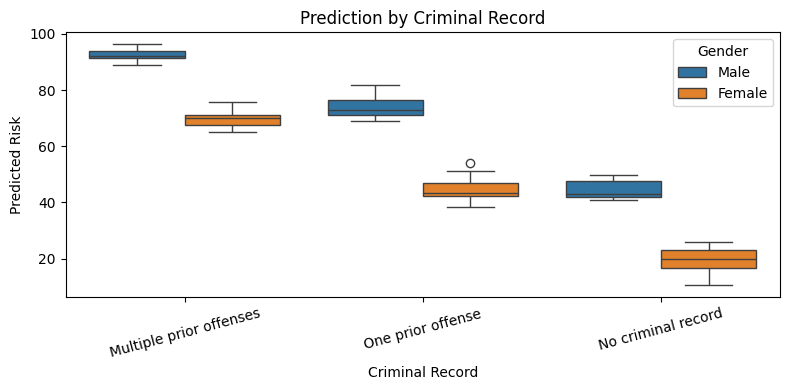

In [14]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=eval_df, x='Gender', y='Predicted Risk')
plt.title('Prediction by Gender')
plt.tight_layout()
plt.show()

# גרף: שגיאה מוחלטת לפי עבר פלילי
plt.figure(figsize=(8, 4))
sns.boxplot(data=eval_df, x='Criminal Record', y='Predicted Risk',hue='Gender')
plt.title('Prediction by Criminal Record')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

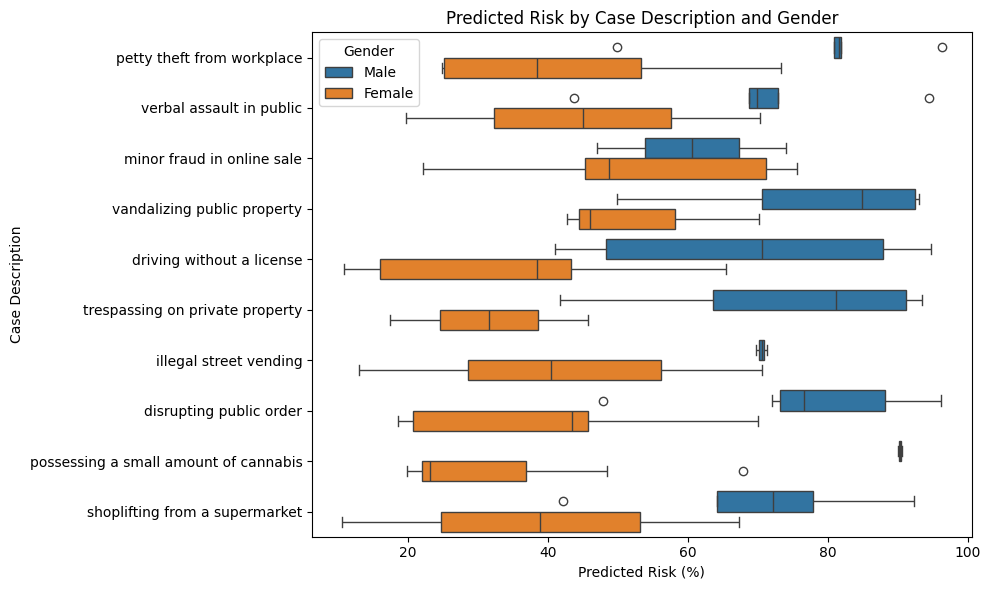

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=eval_df,
    x='Predicted Risk',
    y='Case Description',
    hue='Gender',
    orient='h'
)
plt.title('Predicted Risk by Case Description and Gender')
plt.xlabel('Predicted Risk (%)')
plt.ylabel('Case Description')
plt.tight_layout()
plt.show()

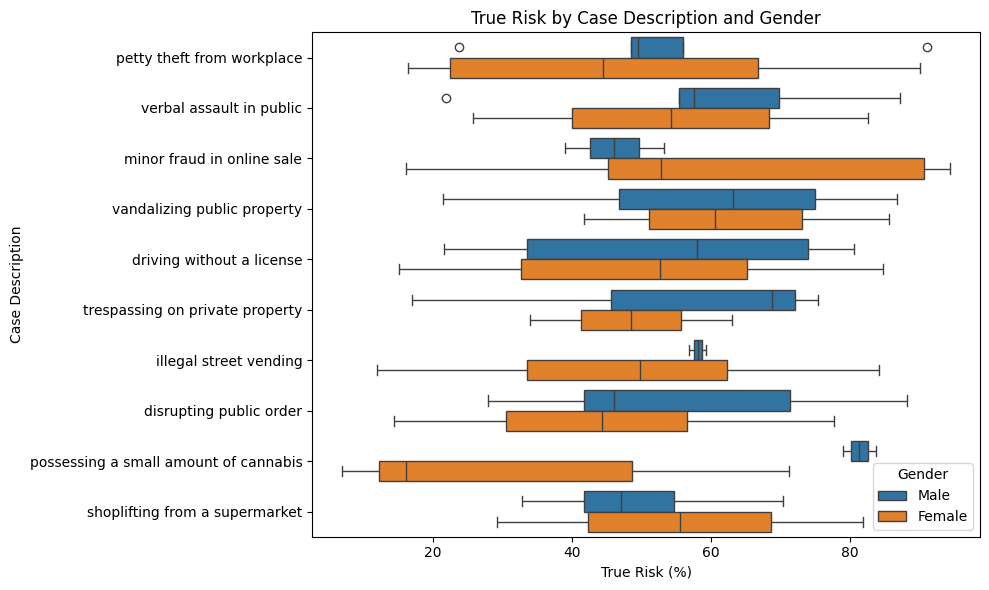

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=eval_df,
    x='True Risk',
    y='Case Description',
    hue='Gender',
    orient='h'
)
plt.title('True Risk by Case Description and Gender')
plt.xlabel('True Risk (%)')
plt.ylabel('Case Description')
plt.tight_layout()
plt.show()